In [7]:
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
from itertools import combinations
import pandas as pd


"""
Classes that contain the implementation of the Fuzzy K-Modes variants
"""


class NaNException(Exception):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

class FuzzyKmodesFuzzyCentroids(object):
    def __init__(self, X, y=None, k=2, m=1.5, n_iter=10, error=0.00005):
        self.X = X
        self.y = y
        self.k = k
        self.m = m
        self.n_iter = n_iter
        self.p = len(X.columns)
        self.n = len(X)
        self.columns = X.columns
        self.u = None
        self.clusters = None
        self.exp = 1 / ( self.m - 1 )
        self.error = error

    def init(self, x, k):
        return [[self.random_numbers(x[attribute].unique())
                for attribute in self.columns]
                for _ in range(self.k)]

    def dissimilarity(self, fuzzy_set, value):
        return sum(0 if term == value else confidence
                for term, confidence in fuzzy_set)
    
    def membership(self, row, cluster, clusters):
        membership = sum((self.distance(cluster, row) /
                          self.distance(other_cluster, row))** self.exp
                         for other_cluster in clusters)
        if np.isnan(membership):
            return 0
        return membership ** -1

    def certainty(self, column, value, cluster_u):
        new_memb = sum(cluster_u[row] ** self.m if x == value else 0
                       for row, x in enumerate(column))
        return new_memb

    def random_numbers(self, values):
        randoms = np.random.dirichlet(np.ones(len(values)), size=1)
        return list(zip(values, randoms[0]))

    def distance(self, cluster, row):
        return sum(self.dissimilarity(fuzzy_set, row[column])
                for column, fuzzy_set in enumerate(cluster))

    def update_clusters(self, clusters, X, u):
        for j, cluster in enumerate(clusters):
            cluster_u = u[j]
            for l, term_membership in enumerate(cluster):
                feature = self.columns[l]
                column = X[feature].values
                clusters[j][l] = [(term, self.certainty(column, term, cluster_u))
                                for term, _ in term_membership]
        return clusters

    def check_normal(self, clusters, iter):
        clusters = [[self.normalize(row) for row in cluster]
                    for cluster in clusters]
        for cluster in clusters:
            for row in cluster:
                if not (0.9 < sum(r[1] for r in row) < 1.1):
                    print('error', row)
                    print('error', sum(r[1] for r in row))
                    raise NaNException(str(iter) + str(cluster))
        return clusters

    def normalize(self, row):
        summed = sum(r[1] for r in row)
        return [(value, x / summed) for value, x in row]

    def fit(self, init=None, memberships=False):
        if not init:
            clusters = self.init(self.X, self.k)
        else:
            clusters = init

        clusters = self.check_normal(clusters, -2)
        u = [[self.membership(row, cluster, clusters) for row in self.X.values]
            for cluster in clusters]
        clusters = self.update_clusters(clusters, self.X, u)
        clusters = self.check_normal(clusters, -1)

        self.iteration = 0
        u_error = 1
        while self.iteration < self.n_iter and u_error > self.error:
            try:
                new_u = [[self.membership(x, cluster, clusters) for x in
                        self.X.values]
                        for cluster in clusters]
                clusters_new = self.update_clusters(clusters, self.X, new_u)
                clusters_new = self.check_normal(clusters_new, self.iteration)
                u_error = np.mean([abs(m - new_m) for i in range(self.k)
                            for m, new_m in zip(u[i], new_u[i])])
                # print(clusters)
                u = new_u
                clusters = clusters_new
            except NaNException:
                print('nan')
                break
            finally:
                self.iteration += 1
        self.u = u
        self.clusters = clusters
        if memberships:
            return self.cluster_membership()

    def cluster_membership(self):
        cluster_membership = {i: list() for i in range(self.k)}
        for i in range(self.n):
            cluster = max((self.u[cl][i], cl) for cl in range(self.k))[-1]
            if type(self.y) is not None:
                value = self.y[i]
            else:
                value = i
            cluster_membership[cluster].append(value)
        return cluster_membership

    def count_values(self, cluster_membership):
        return {cl: Counter(vals) for cl, vals in cluster_membership.items()}

    def plot_clusters(self):
        cluster_membership = self.cluster_membership()
        cluster_membershp = {cl: Counter(vals)
                             for cl, vals in cluster_membership.items()}
        for cl, vals in cluster_membership.items():
            plt.subplot(1, self.k, cl+ 1 )
            if vals:
                # Filter out the NaN values.
                plt.hist([v for v in vals if v ==v])
        plt.show()


In [9]:
"""
Fit the clusterer on the data and return the results of classifying the datapoints using the clusters
"""

# Read the mushroom data-set as a dataframe
print("Reading and processing the mushroom data-set..")
df = pd.read_csv('Data_fuzzy-shrooms.csv').dropna()
X = df.drop('class', axis=1)
columns = combinations(X.columns, 2)
y = df['class']


# Fit the clusterer
m = 1 + (9 * 0.1)
print("Fitting clusterer...", end=" ")
clust = FuzzyKmodesFuzzyCentroids(X, y, m=m)
clust.fit()
print('Clusterer fit')

# Retrieve the total values of the memberships of the datapoints per cluster
clusters = clust.count_values(clust.cluster_membership())
cl1 = clusters[0]
cl2 = clusters[1]
print("Cluster 1: {}".format(cl1))
print("Cluster 2: {}".format(cl2))

Reading and processing the mushroom data-set..
Fitting clusterer... Clusterer fit
Cluster 1: Counter({'p': 3100, 'e': 89})
Cluster 2: Counter({'e': 4119, 'p': 816})


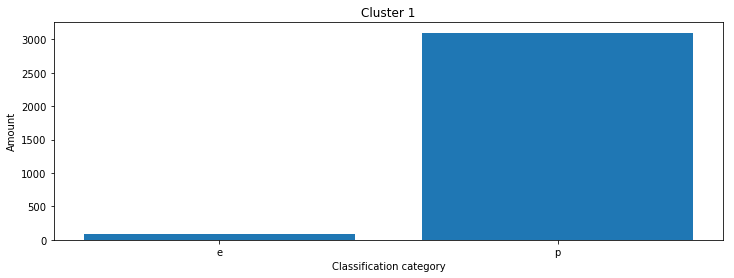

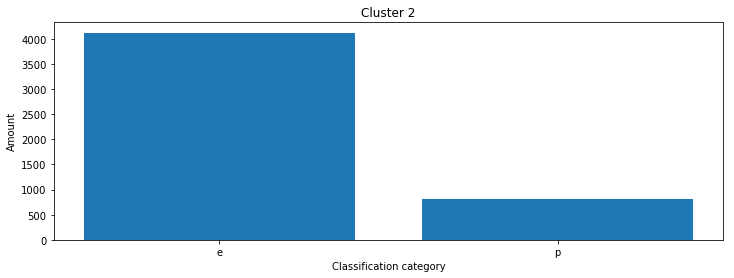

In [10]:
# Labels of the classification
labels = ['e', 'p']

# Plot cluster 1
plt.figure(figsize=(12, 4))
plt.bar(range(len(labels)), [cl1[label] for label in labels])
plt.xticks(range(len(labels)), labels)
plt.title("Cluster 1")
plt.xlabel("Classification category")
plt.ylabel("Amount")
plt.show()

# Plot cluster 2
plt.figure(figsize=(12, 4))
plt.bar(range(len(labels)), [cl2[label] for label in labels])
plt.xticks(range(len(labels)), labels)
plt.title("Cluster 2")
plt.xlabel("Classification category")
plt.ylabel("Amount")
plt.show()